<a href="https://colab.research.google.com/github/Allexxandr/data-analytics-project-100/blob/main/charts_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создаем Jypyter Notebook и подключаем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
import os
from pathlib import Path

In [2]:
!pip install dotenv

In [3]:
from dotenv import load_dotenv

In [4]:
# Получаем текущую директорию
current_directory = os.getcwd()

# Создаем путь к папке charts в текущей директории
charts_directory = os.path.join(current_directory, 'charts')

# Проверяем, существует ли папка charts; если нет, создаем ее
if not os.path.exists(charts_directory):
    os.makedirs(charts_directory)
    print(f"Папка 'charts' создана в {current_directory}")
else:
    print(f"Папка 'charts' уже существует в {current_directory}")

/content


In [5]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

Содержимое файла .env:
DATE_BEGIN=2023-03-01
DATE_END=2023-09-01
API_URL=https://data-charts-api.hexlet.app

Значения переменных:
DATE_BEGIN: 2023-03-01
DATE_END: 2023-09-01
API_URL: https://data-charts-api.hexlet.app


In [7]:
url_visit = f'{API_URL}/visits'
params = {
    'begin': DATE_BEGIN,
    'end': DATE_END
}
resp1 = requests.get(url_visit, params=params)
visits = pd.DataFrame(resp1.json())

# Filter out bot traffic
visits = visits[visits['user_agent'] != 'bot']

# Handle datetime conversion with error handling
visits['datetime'] = pd.to_datetime(visits['datetime'], errors='coerce')

# Fill any NaT values with a safe default
visits['datetime'] = visits['datetime'].fillna(pd.Timestamp.min)

# Sort and group the data
df = visits.sort_values(by='datetime', ascending=False)
latest_visits = df.groupby('visit_id').first().reset_index()
latest_visits['date_group'] = latest_visits['datetime'].dt.date
visits_group = latest_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')

print(visits_group)

     date_group platform  visits
0    2023-03-01  android      75
1    2023-03-01      ios      22
2    2023-03-01      web     279
3    2023-03-02  android      67
4    2023-03-02      ios      31
..          ...      ...     ...
589  2023-08-30      ios      66
590  2023-08-30      web    1227
591  2023-08-31  android      57
592  2023-08-31      ios      50
593  2023-08-31      web     721

[594 rows x 3 columns]


In [8]:
url_reg = f'{API_URL}/registrations'
resp2 = requests.get(url_reg, params=params)
reg = pd.DataFrame(resp2.json())

reg = reg.sort_values(by='datetime')
reg['datetime'] = pd.to_datetime(reg['datetime'])


reg['date_group'] = reg['datetime'].dt.date

reg.head()

,datetime,user_id,email,platform,registration_type,date_group
3,2023-03-01 00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email,2023-03-01
28,2023-03-01 00:23:00,b7ec78b7-fdf6-443c-bba6-01e719c26efe,smithrachel@example.net,android,google,2023-03-01
22,2023-03-01 00:55:55,2aeb1afe-7641-416f-a21b-d747dbe8d754,kendra89@example.com,android,google,2023-03-01
20,2023-03-01 01:02:01,7188b134-a628-4138-9d46-545fb99a91a7,ghernandez@example.net,android,email,2023-03-01
55,2023-03-01 01:04:22,93ae2189-9f3c-47ea-ba0a-b06db9fb43ae,lisa22@example.net,android,google,2023-03-01


In [12]:
visits.describe()


,datetime
count,263459
mean,2023-06-01 06:22:22.042044672
min,2023-03-01 00:00:43
25%,2023-04-13 19:45:03
50%,2023-06-03 12:23:27
75%,2023-07-17 22:09:08
max,2023-08-31 23:52:57


In [13]:
reg.describe()

,datetime
count,21836
mean,2023-05-29 10:17:02.002747648
min,2023-03-01 00:04:47
25%,2023-04-12 01:49:47.500000
50%,2023-05-26 13:22:09
75%,2023-07-15 17:26:30.500000
max,2023-08-31 23:43:26


In [14]:
visits_group = latest_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')


reg_group = reg.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

conversion = pd.merge(visits_group, reg_group, how='inner', on=['date_group', 'platform']).fillna(0)

conversion['visits'] = conversion['visits'].fillna(0)
conversion['registrations'] = conversion['registrations'].fillna(0)

conversion['conversion'] = (conversion['registrations'] * 100.0 / conversion['visits']).fillna(0)

conversion.to_json('./conversion.json')

conversion.head(70)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
65,2023-03-22,web,341,30,8.797654
66,2023-03-23,android,66,55,83.333333
67,2023-03-23,ios,39,32,82.051282
68,2023-03-23,web,603,36,5.970149


In [15]:
import json

with open('conversion.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4, ensure_ascii=False))

{
    "date_group": {
        "0": 1677628800000,
        "1": 1677628800000,
        "2": 1677628800000,
        "3": 1677715200000,
        "4": 1677715200000,
        "5": 1677715200000,
        "6": 1677801600000,
        "7": 1677801600000,
        "8": 1677801600000,
        "9": 1677888000000,
        "10": 1677888000000,
        "11": 1677888000000,
        "12": 1677974400000,
        "13": 1677974400000,
        "14": 1677974400000,
        "15": 1678060800000,
        "16": 1678060800000,
        "17": 1678060800000,
        "18": 1678147200000,
        "19": 1678147200000,
        "20": 1678147200000,
        "21": 1678233600000,
        "22": 1678233600000,
        "23": 1678233600000,
        "24": 1678320000000,
        "25": 1678320000000,
        "26": 1678320000000,
        "27": 1678406400000,
        "28": 1678406400000,
        "29": 1678406400000,
        "30": 1678492800000,
        "31": 1678492800000,
        "32": 1678492800000,
        "33": 1678579200000,
  

In [ ]:
# Сначала выполняем исходные преобразования
ads_campaign = pd.read_csv('ads.csv')
ads_campaign = ads_campaign.sort_values(by='date')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.strftime('%Y-%m-%d')
ads_campaign = ads_campaign.rename(columns={'date': 'date_group'})

# Группируем данные по рекламным кампаниям, используя first() вместо sum()
ads_cost = ads_campaign.groupby(['date_group', 'utm_campaign'])['cost'].first().reset_index()

# Используем полное внешнее соединение для сохранения всех записей
ads_merge = pd.merge(conversion, ads_cost, how='outer', on='date_group')

# Заполняем пропуски нулями только для числовых столбцов
for col in ['visits', 'registrations', 'cost', 'conversion']:
    ads_merge[col] = ads_merge[col].fillna(0)

# Обрабатываем utm_campaign
ads_merge['utm_campaign'] = ads_merge['utm_campaign'].fillna('NULL')

# Группируем результаты
ads = ads_merge.groupby(['date_group', 'utm_campaign']).first().reset_index()  # Используем first() вместо sum()
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign', 'conversion']]

# Пересчитываем коэффициент конверсии
ads['conversion'] = (ads['registrations'] * 100.0 / ads['visits']).replace([np.inf, np.nan], 0)

# Сохраняем результат
ads.to_json('./ads.json')


ads.head(150)

In [88]:
os.makedirs('charts', exist_ok=True)

# Verify the directory exists
print(os.listdir())

['.config', '.env', 'ads.json', 'conversion.json', 'charts', 'sample_data']


In [89]:
print(os.getcwd())

/content


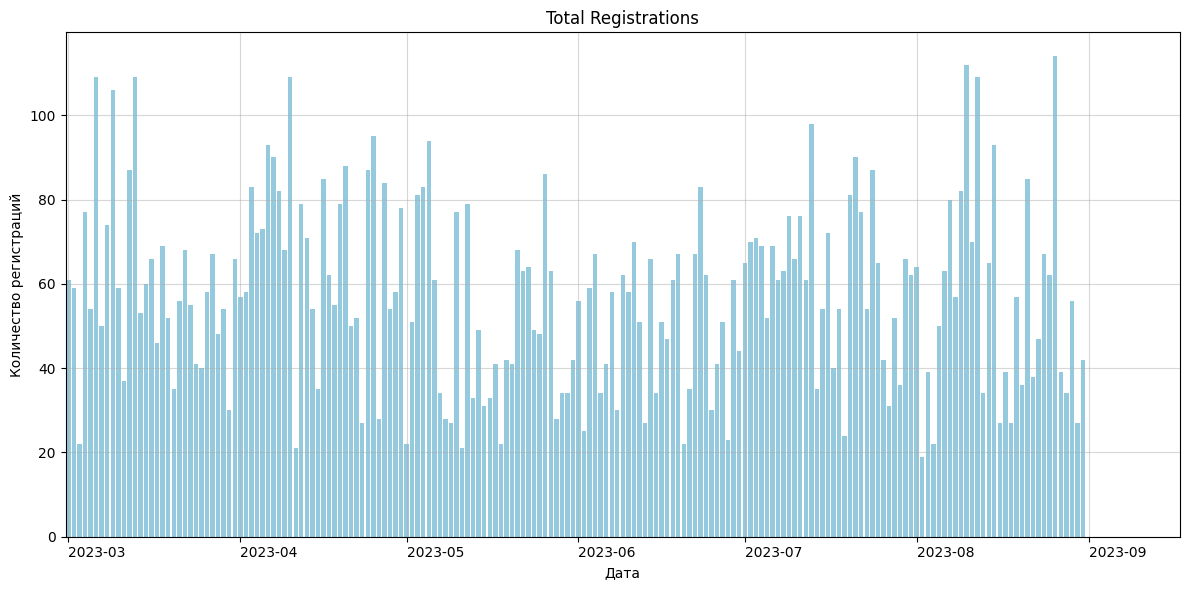

In [90]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='registrations', color='skyblue')

ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

plt.xticks(
    ticks=monthly_ticks.index,
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.title('Total Registrations')
plt.grid(alpha=0.5)
plt.tight_layout()

plt.savefig(os.path.join(charts_directory, 'total_registrations'))
plt.show()

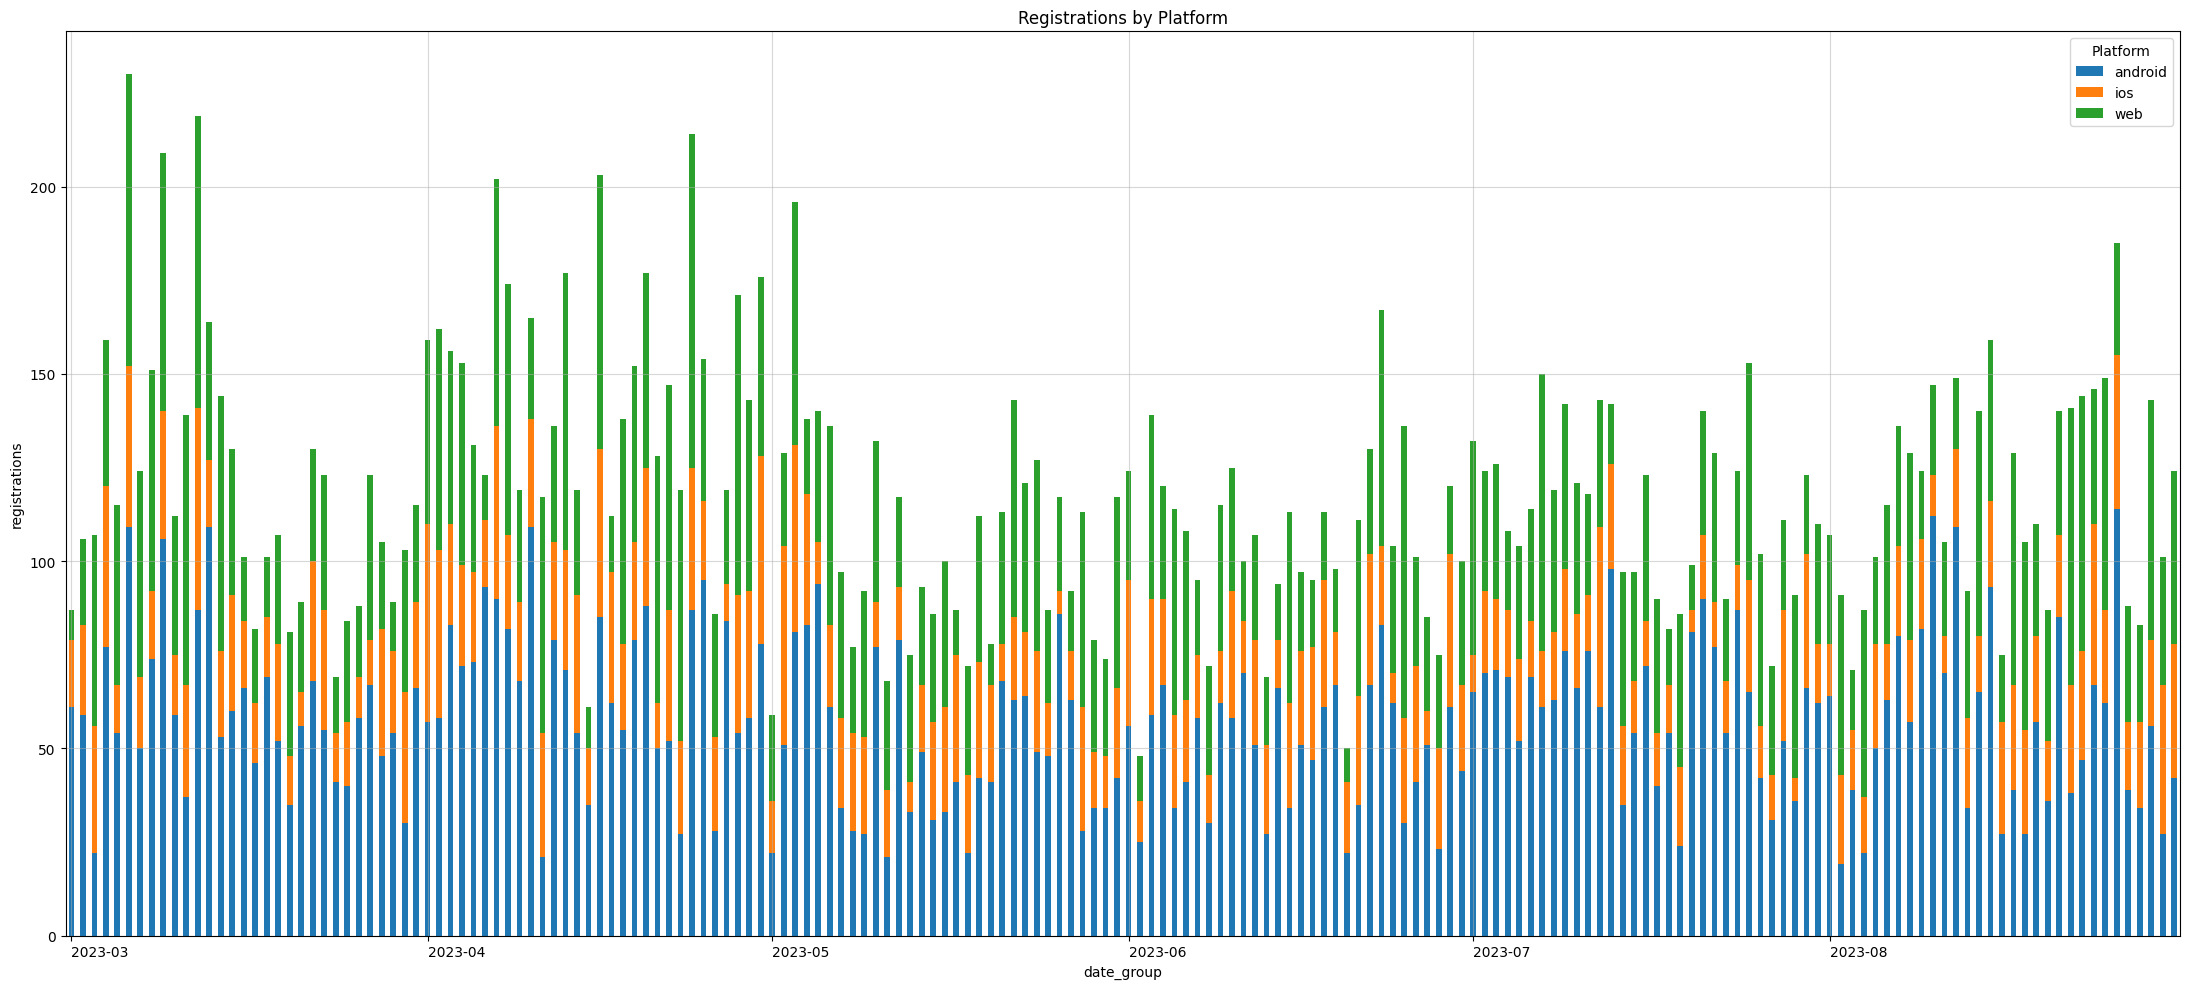

In [91]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='registrations', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Registrations by Platform')

stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(alpha=0.5)
plt.legend(title='Platform')

plt.tight_layout()

plt.savefig(os.path.join(charts_directory, 'visits_by_platform'))

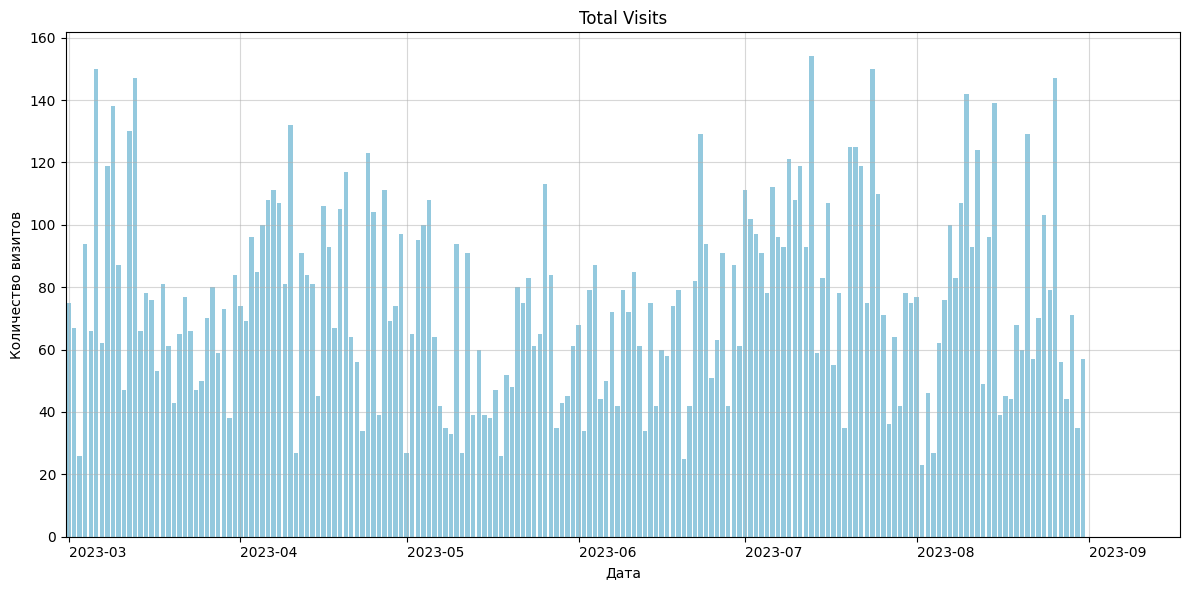

In [92]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='visits', color='skyblue')

ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

plt.xticks(
    ticks=monthly_ticks.index,
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Total Visits')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'total_visits'))
plt.show()

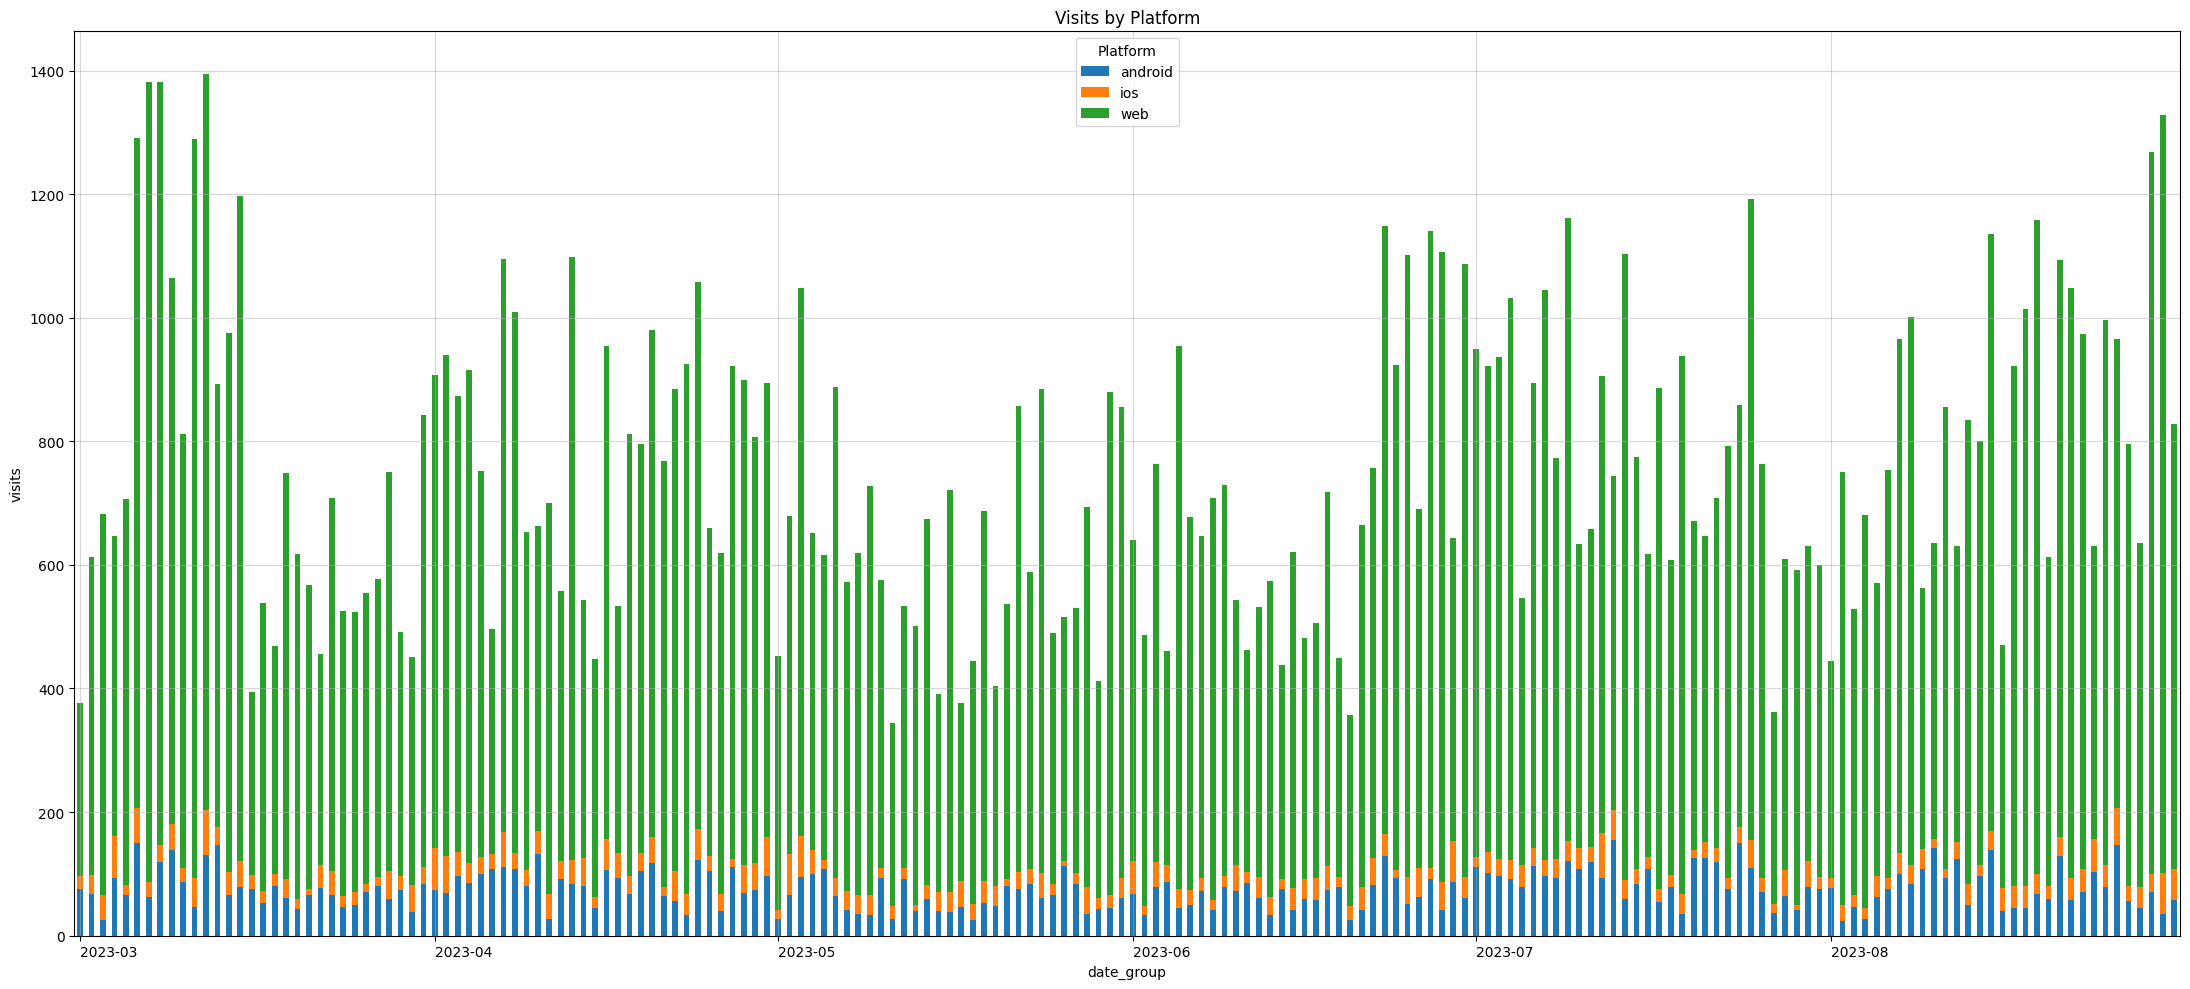

In [93]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='visits', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Visits by Platform')

stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

plt.grid(alpha=0.5)
plt.legend(title='Platform')

plt.tight_layout()

plt.savefig(os.path.join(charts_directory, 'visits_by_platform'))

In [94]:
print("Все доступные столбцы:")
print(ads.columns.tolist())

# Проверяем типы данных
print("\nТипы данных столбцов:")
print(ads.dtypes)

# Проверяем первые несколько строк данных
print("\nПример данных:")
print(ads.head())

Все доступные столбцы:
['date_group', 'visits', 'registrations', 'cost', 'utm_campaign', 'conversion', 'year_month']

Типы данных столбцов:
date_group       datetime64[ns]
visits                  float64
registrations           float64
cost                    float64
utm_campaign             object
conversion              float64
year_month            period[M]
dtype: object

Пример данных:
  date_group  visits  registrations   cost                utm_campaign  \
0 2023-03-01    75.0           61.0  212.0  advanced_algorithms_series   
1 2023-03-02    67.0           59.0  252.0  advanced_algorithms_series   
2 2023-03-03    26.0           22.0  202.0  advanced_algorithms_series   
3 2023-03-04    94.0           77.0  223.0  advanced_algorithms_series   
4 2023-03-05    66.0           54.0  265.0  advanced_algorithms_series   

   conversion year_month  
0   81.333333    2023-03  
1   88.059701    2023-03  
2   84.615385    2023-03  
3   81.914894    2023-03  
4   81.818182    2023-03  

In [95]:
filtered_df = ads[(ads['date_group'].astype(str) >= '2023-03-01') & (ads['date_group'].astype(str) <= '2023-09-01')]
filtered_df_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()
grouped_data = filtered_df.groupby('date_group')['visits'].sum().reset_index()
# Преобразование столбца даты в формат datetime
ads['date_group'] = pd.to_datetime(ads['date_group'])

# Извлечение года и месяца и добавление их в отдельные столбцы
ads['year_month'] = ads['date_group'].dt.to_period('M')

# Группировка данных по годам и месяцам и
# расчет средней конверсии за месяц
daily_conversion = (
    filtered_df.groupby('date_group')['conversion']
    .mean()
    .reset_index()
)

# Преобразование конверсии в проценты


print(daily_conversion)

    date_group  conversion
0   2023-03-01   81.333333
1   2023-03-02   88.059701
2   2023-03-03   84.615385
3   2023-03-04   81.914894
4   2023-03-05   81.818182
..         ...         ...
180 2023-08-28   77.272727
181 2023-08-29   78.873239
182 2023-08-30   77.142857
183 2023-08-31   73.684211
184 2023-09-01    0.000000

[185 rows x 2 columns]


In [96]:
filtered_df_conversion = conversion[(conversion['date_group'].astype(str) >= '2023-03-01') & (conversion['date_group'].astype(str) <= '2023-09-01')]

# Отфильтруем 3 датасета по каждой из платформ
android_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion']

ios_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion']

web_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion']

web_df.head()

,date_group,platform,visits,registrations,conversion
2,2023-03-01,web,279,8,2.867384
5,2023-03-02,web,515,23,4.466019
8,2023-03-03,web,617,51,8.265802
11,2023-03-04,web,485,39,8.041237
14,2023-03-05,web,625,48,7.680000


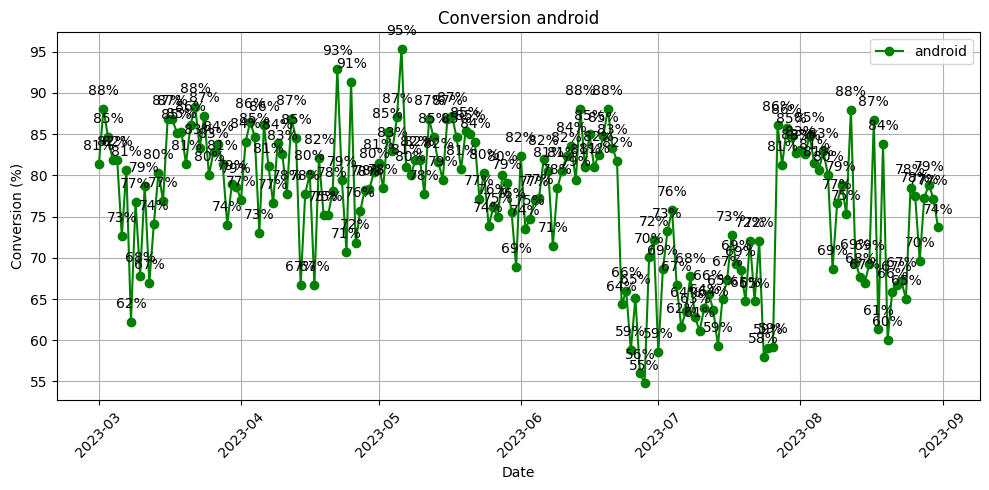

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='green', label='android')

for i, txt in enumerate(android_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conversion android')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_android'))
plt.show()

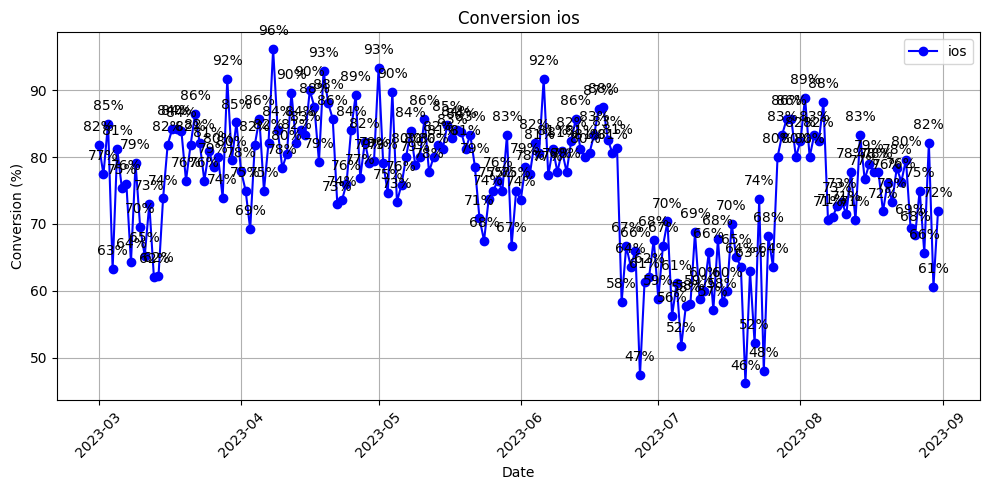

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='blue', label='ios')

for i, txt in enumerate(ios_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion ios')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_ios'))
plt.show()

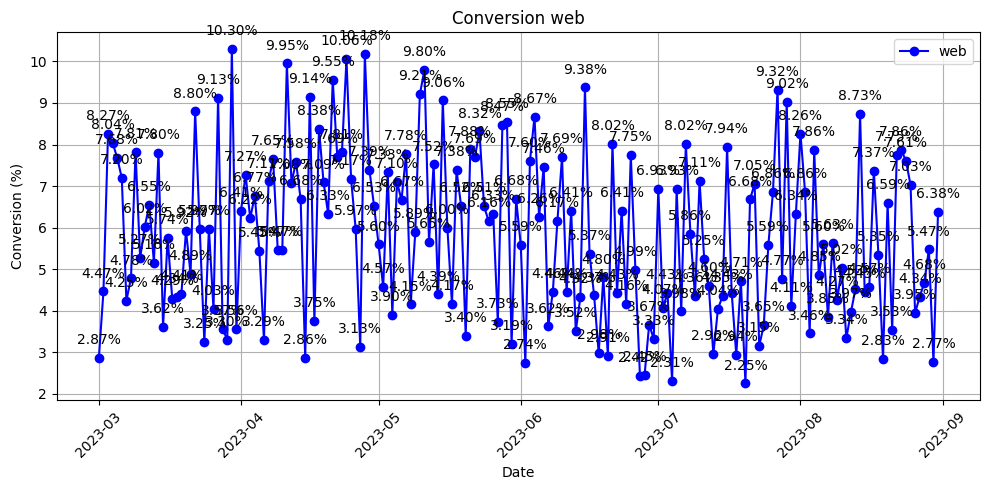

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='blue', label='web')

for i, txt in enumerate(web_df['conversion']):
    plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion web')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_web'))
plt.show()

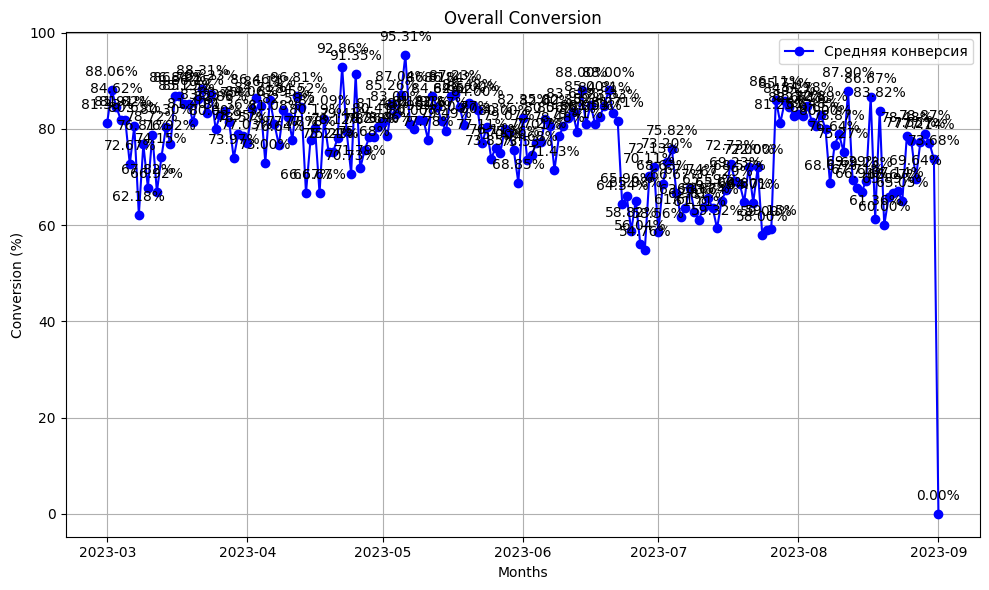

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(daily_conversion['date_group'], daily_conversion['conversion'], marker='o', linestyle='-', color='b', label='Средняя конверсия')

for i, txt in enumerate(daily_conversion['conversion']):
    plt.annotate(f'{txt:.2f}%', (daily_conversion['date_group'][i], daily_conversion['conversion'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Months')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'overall_conversion'))
plt.show()

In [101]:
ads['date_group'] = pd.to_datetime(ads['date_group'])

mask = (ads['date_group'] >= '2023-03-01') & (ads['date_group'] <= '2023-09-01')
filtered_df_costs = ads.loc[mask]

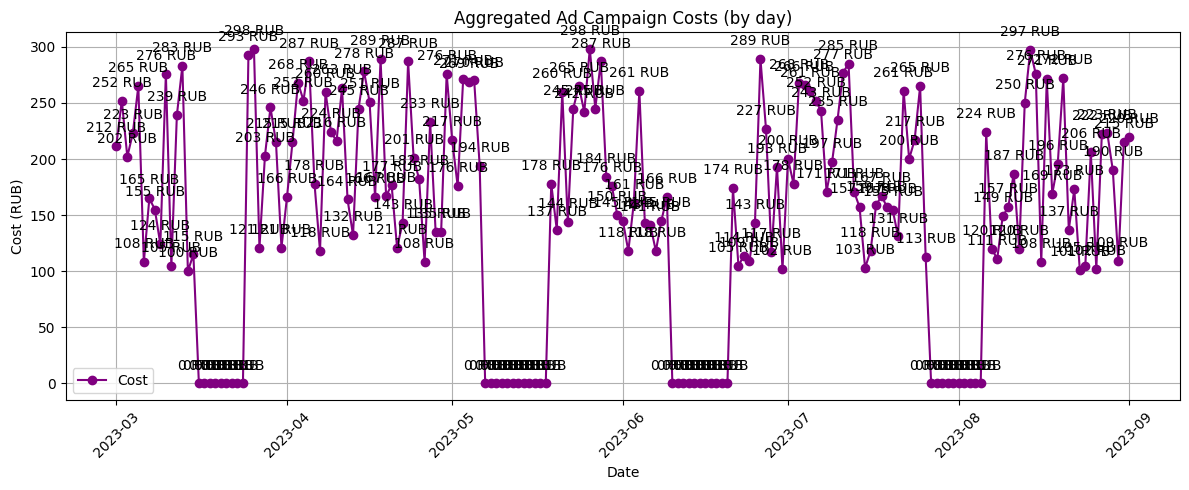

In [102]:
plt.figure(figsize=(12, 5))
plt.plot(filtered_df_costs['date_group'], filtered_df_costs['cost'], marker='o', linestyle='-', color='purple', label='Cost')

for i, txt in enumerate(filtered_df_costs['cost']):
    plt.annotate(f'{txt:.0f} RUB', (filtered_df_costs['date_group'].iloc[i], filtered_df_costs['cost'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'aggregated_ad_campaign_costs'))
plt.show()

NameError: name 'mdates' is not defined

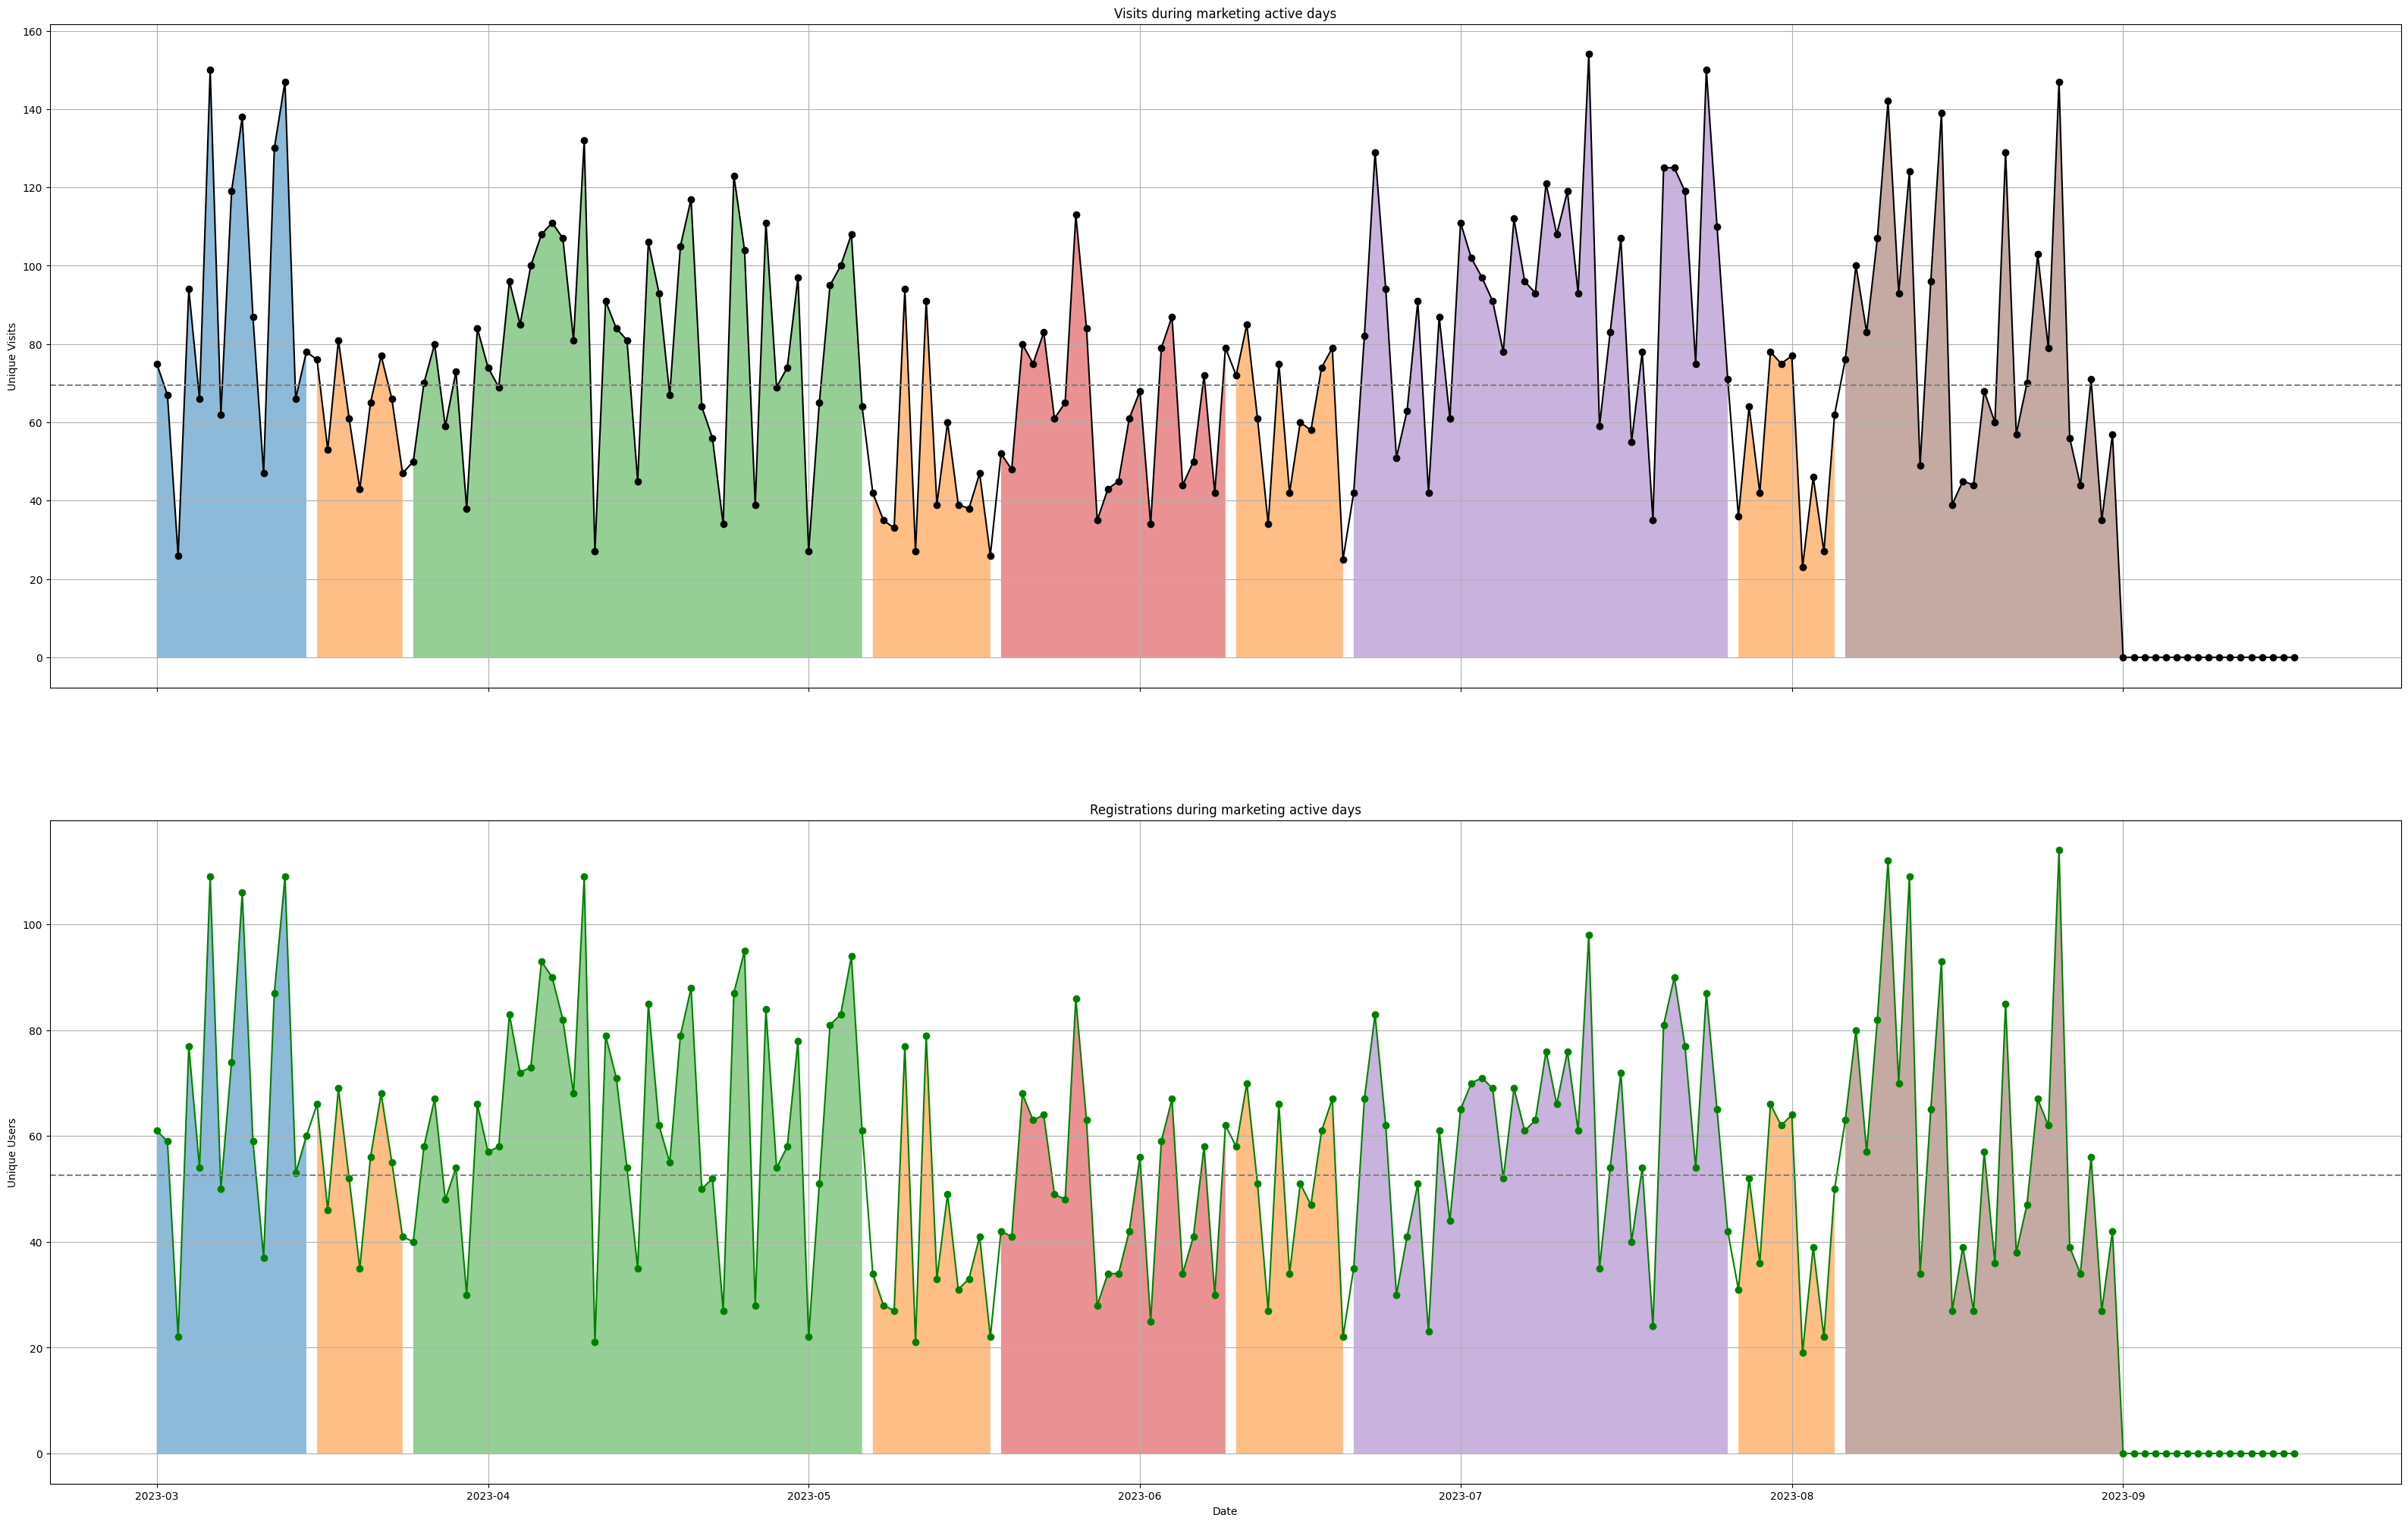

In [103]:
ads = ads[(ads['date_group'].astype(str) >= '2023-03-01') & (ads['date_group'].astype(str) <= '2023-9-01')]
unique_campaigns = ads[ads['utm_campaign'] != 0]['utm_campaign'].unique()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25), sharex=True)

handles, labels = {}, {}

# График визитов
visits_line, = ax1.plot(ads['date_group'], ads['visits'], marker='o', linestyle='-', color='black', label='Visits')
visits_mean = ax1.axhline(ads['visits'].mean(), color='gray', linestyle='--', label='Average Number of Visits')
handles.update({visits_line.get_label(): visits_line, visits_mean.get_label(): visits_mean})

for campaign in unique_campaigns:
    campaign_mask = ads['utm_campaign'] == campaign
    fill = ax1.fill_between(ads['date_group'], ads['visits'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax1.set_ylabel('Unique Visits')
ax1.set_title('Visits during marketing active days')
ax1.grid(True)

# График регистраций
registrations_line, = ax2.plot(ads['date_group'], ads['registrations'], marker='o', linestyle='-', color='green', label='Registrations')
registrations_mean = ax2.axhline(ads['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registration')
handles.update({registrations_line.get_label(): registrations_line, registrations_mean.get_label(): registrations_mean})

for campaign in unique_campaigns:
    campaign_mask = ads['utm_campaign'] == campaign
    fill = ax2.fill_between(ads['date_group'], ads['registrations'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax2.set_ylabel('Unique Users')
ax2.set_title('Registrations during marketing active days')
ax2.grid(True)

# Настройка оси X
ax2.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Расположение общей легенды
fig.legend(handles.values(), labels=[h.get_label() for h in handles.values()], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig(os.path.join(charts_directory, 'v_and_re_during_marketing_active_days'))

plt.show()